## Conversion of a CPU consumption time series into means and standard deviation to calculate the next peak occurrences using a neural network

### Imports

In [22]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.initializers import VarianceScaling
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import KFold
from sklearn.metrics import cohen_kappa_score

### Read the data

In [23]:
df = pd.read_csv('../data/cpu-7day.csv')
data = df.iloc[:, 1].values

In [24]:
pd.DataFrame(data)

,0
0,27.6
1,0.7
2,1.0
3,2.7
4,0.9
...,...
10075,29.8
10076,8.7
10077,13.6
10078,2.1


### Divide the data into blocks of 50 elements, where each new block it moves 10 elements

In [25]:
blocks_data = []
for i in np.arange(0, int(data.shape[0]-40), 10):
    blocks_data.append(data[i:i+50])
blocks_data = np.array(blocks_data)

### Then divide the blocks into 5 parts (10x5 = 50)

In [26]:
parts_data = blocks_data.reshape(-1, 5, 10)

### Calculate average and deviation of each part

In [27]:
mean_parts_data = np.mean(parts_data, axis = -1)
std_parts_data = np.std(parts_data, axis = -1, ddof = 1)

### Take the next 20 elements from each block of 50 elements

In [28]:
next_data = []
for i in np.arange(50, int(data.shape[0]-10), 10):
    next_data.append(data[i:i+20])
next_data = np.array(next_data)

### Calculate how many readings there are from 0 to 100, grouping every 20

In [29]:
count_groups = np.array([np.sum(((0<=next_data) & (next_data<20))*1, axis = -1),
                         np.sum(((20<=next_data) & (next_data<40))*1, axis = -1),
                         np.sum(((40<=next_data) & (next_data<60))*1, axis = -1),
                         np.sum(((60<=next_data) & (next_data<80))*1, axis = -1),
                         np.sum(((80<=next_data) & (next_data<100))*1, axis = -1)]).T

### Collect all and merge in new dataframe

In [30]:
mean_std = np.append(mean_parts_data.reshape(-1, 1), std_parts_data.reshape(-1, 1), axis = -1).reshape(-1, 10)
pad_count_groups = np.pad(count_groups, (0, mean_std.shape[0]-count_groups.shape[0]))[:, :5]
res_data = np.append(mean_std, pad_count_groups, axis = 1)

### View data

In [31]:
columns = ['mean_1', 'std_1', 'mean_2', 'std_2', 'mean_3', 'std_3', 'mean_4', 'std_4', 'mean_5', 'std_5',
           '0_20', '20_40', '40_60', '60_80', '80_100']
DF = pd.DataFrame(res_data, columns = columns)

In [32]:
DF

,mean_1,std_1,mean_2,std_2,mean_3,std_3,mean_4,std_4,mean_5,std_5,0_20,20_40,40_60,60_80,80_100
0,4.26,8.291388,4.86,4.741823,7.83,9.558248,3.14,2.254477,1.99,1.340357,18.0,0.0,2.0,0.0,0.0
1,4.86,4.741823,7.83,9.558248,3.14,2.254477,1.99,1.340357,5.90,12.272100,19.0,0.0,1.0,0.0,0.0
2,7.83,9.558248,3.14,2.254477,1.99,1.340357,5.90,12.272100,5.76,12.876093,19.0,0.0,1.0,0.0,0.0
3,3.14,2.254477,1.99,1.340357,5.90,12.272100,5.76,12.876093,2.97,2.762064,19.0,0.0,1.0,0.0,0.0
4,1.99,1.340357,5.90,12.272100,5.76,12.876093,2.97,2.762064,8.58,12.772262,20.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999,3.58,3.813951,1.72,2.093270,8.48,14.654449,2.20,2.688659,3.13,3.694155,19.0,1.0,0.0,0.0,0.0
1000,1.72,2.093270,8.48,14.654449,2.20,2.688659,3.13,3.694155,6.27,10.241425,20.0,0.0,0.0,0.0,0.0
1001,8.48,14.654449,2.20,2.688659,3.13,3.694155,6.27,10.241425,2.70,3.612940,19.0,1.0,0.0,0.0,0.0
1002,2.20,2.688659,3.13,3.694155,6.27,10.241425,2.70,3.612940,1.33,1.255256,0.0,0.0,0.0,0.0,0.0


### Normalization, dividing all column elements by the highest occurrence of the column itself (0,1)

In [33]:
revert = DF.max()
DF.max()

mean_1    16.910000
std_1     31.063297
mean_2    16.910000
std_2     31.063297
mean_3    16.910000
std_3     31.063297
mean_4    16.910000
std_4     31.063297
mean_5    16.910000
std_5     31.063297
0_20      20.000000
20_40      5.000000
40_60      2.000000
60_80      1.000000
80_100     1.000000
dtype: float64

In [34]:
DF.divide(DF.max())

,mean_1,std_1,mean_2,std_2,mean_3,std_3,mean_4,std_4,mean_5,std_5,0_20,20_40,40_60,60_80,80_100
0,0.251922,0.266919,0.287404,0.152650,0.463040,0.307702,0.185689,0.072577,0.117682,0.043149,0.90,0.0,1.0,0.0,0.0
1,0.287404,0.152650,0.463040,0.307702,0.185689,0.072577,0.117682,0.043149,0.348906,0.395068,0.95,0.0,0.5,0.0,0.0
2,0.463040,0.307702,0.185689,0.072577,0.117682,0.043149,0.348906,0.395068,0.340627,0.414511,0.95,0.0,0.5,0.0,0.0
3,0.185689,0.072577,0.117682,0.043149,0.348906,0.395068,0.340627,0.414511,0.175636,0.088917,0.95,0.0,0.5,0.0,0.0
4,0.117682,0.043149,0.348906,0.395068,0.340627,0.414511,0.175636,0.088917,0.507392,0.411169,1.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999,0.211709,0.122780,0.101715,0.067387,0.501478,0.471761,0.130101,0.086554,0.185098,0.118923,0.95,0.2,0.0,0.0,0.0
1000,0.101715,0.067387,0.501478,0.471761,0.130101,0.086554,0.185098,0.118923,0.370787,0.329695,1.00,0.0,0.0,0.0,0.0
1001,0.501478,0.471761,0.130101,0.086554,0.185098,0.118923,0.370787,0.329695,0.159669,0.116309,0.95,0.2,0.0,0.0,0.0
1002,0.130101,0.086554,0.185098,0.118923,0.370787,0.329695,0.159669,0.116309,0.078652,0.040410,0.00,0.0,0.0,0.0,0.0


In [35]:
DF = DF.divide(DF.max())

## Dividing averages/deviation in X and counts in Y

### Viewing the neuron input

,mean_1,std_1,mean_2,std_2,mean_3,std_3,mean_4,std_4,mean_5,std_5
0,0.251922,0.266919,0.287404,0.152650,0.463040,0.307702,0.185689,0.072577,0.117682,0.043149
1,0.287404,0.152650,0.463040,0.307702,0.185689,0.072577,0.117682,0.043149,0.348906,0.395068
2,0.463040,0.307702,0.185689,0.072577,0.117682,0.043149,0.348906,0.395068,0.340627,0.414511
3,0.185689,0.072577,0.117682,0.043149,0.348906,0.395068,0.340627,0.414511,0.175636,0.088917
4,0.117682,0.043149,0.348906,0.395068,0.340627,0.414511,0.175636,0.088917,0.507392,0.411169
...,...,...,...,...,...,...,...,...,...,...
999,0.211709,0.122780,0.101715,0.067387,0.501478,0.471761,0.130101,0.086554,0.185098,0.118923
1000,0.101715,0.067387,0.501478,0.471761,0.130101,0.086554,0.185098,0.118923,0.370787,0.329695
1001,0.501478,0.471761,0.130101,0.086554,0.185098,0.118923,0.370787,0.329695,0.159669,0.116309
1002,0.130101,0.086554,0.185098,0.118923,0.370787,0.329695,0.159669,0.116309,0.078652,0.040410


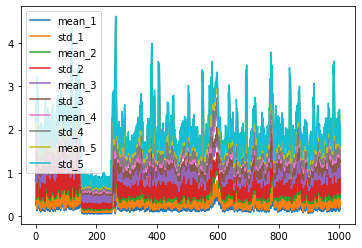

In [36]:
X = DF.iloc[:, 0:10]

X.plot(kind='line', stacked=True); X

### Visualizing the output of the neuron

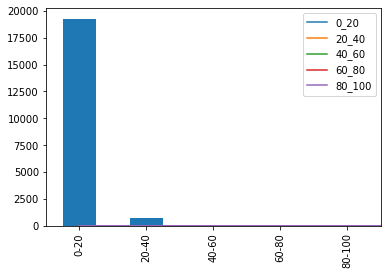

In [37]:
Y = DF.iloc[:, 10:15];

Y.plot(kind='line', stacked=True);
pd.DataFrame(count_groups, columns = ['0-20','20-40','40-60','60-80','80-100']).sum().plot(kind='bar', stacked=True)

### Visualizing the shape of the axes

In [38]:
X.shape, Y.shape

((1004, 10), (1004, 5))

### Preparing cross validation k = 5

In [39]:
kfold = KFold(5, False, 1)

### Training:

In [40]:
cvscores = []
for train, test in kfold.split(X,Y):

    model = Sequential()
    model.add(Dense(10,
                kernel_regularizer=l2(0.001),
                kernel_initializer=VarianceScaling(), 
                activation='sigmoid',
                name='hidden-input'))
    model.add(Dense(5, 
                kernel_regularizer=l2(0.001),
                kernel_initializer=VarianceScaling(),                 
                activation='sigmoid',
                name='output'))
    
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    
    model.fit(X.iloc[train].values, Y.iloc[train].values, epochs=100, batch_size=5, verbose = 0, shuffle=False,
              validation_data=(X.iloc[test].values, Y.iloc[test].values))

    scores = model.evaluate(X.iloc[test].values, Y.iloc[test].values, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

mse: 1.60%
mse: 1.16%
mse: 0.84%
mse: 1.15%
mse: 1.10%
1.17% (+/- 0.24%)


### Viewing the network structure

In [41]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden-input (Dense)         multiple                  110       
_________________________________________________________________
output (Dense)               multiple                  55        
Total params: 165
Trainable params: 165
Non-trainable params: 0
_________________________________________________________________


### Generating prediction based on X readings

In [42]:
y = model.predict(X)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [43]:
len(X)

1004

In [44]:
result = pd.DataFrame(y); result

,0,1,2,3,4
0,0.962622,0.135029,0.032634,0.012159,0.020513
1,0.962622,0.135020,0.032632,0.012159,0.020512
2,0.962622,0.135025,0.032633,0.012159,0.020512
3,0.962622,0.135030,0.032634,0.012159,0.020513
4,0.962622,0.135023,0.032633,0.012159,0.020512
...,...,...,...,...,...
999,0.962622,0.135030,0.032634,0.012159,0.020513
1000,0.962622,0.135019,0.032632,0.012159,0.020512
1001,0.962622,0.135029,0.032634,0.012159,0.020513
1002,0.962622,0.135028,0.032634,0.012159,0.020512


### Reverting binary values to decimals

In [45]:
maxOccurrence = revert[10:15]; maxOccurrence

0_20      20.0
20_40      5.0
40_60      2.0
60_80      1.0
80_100     1.0
dtype: float64

In [46]:
speak = result.multiply(maxOccurrence.values);speak

,0,1,2,3,4
0,19.252441,0.675144,0.065267,0.012159,0.020513
1,19.252449,0.675102,0.065265,0.012159,0.020512
2,19.252443,0.675125,0.065266,0.012159,0.020512
3,19.252438,0.675151,0.065268,0.012159,0.020513
4,19.252445,0.675116,0.065266,0.012159,0.020512
...,...,...,...,...,...
999,19.252438,0.675150,0.065268,0.012159,0.020513
1000,19.252449,0.675095,0.065265,0.012159,0.020512
1001,19.252438,0.675145,0.065267,0.012159,0.020513
1002,19.252441,0.675140,0.065267,0.012159,0.020512


### Grouping data into occurrences for sum

In [47]:
next_data = np.array(speak)
count_groups = np.array([np.sum(((0<=next_data) & (next_data<20))*1, axis = -1),
                         np.sum(((20<=next_data) & (next_data<40))*1, axis = -1),
                         np.sum(((40<=next_data) & (next_data<60))*1, axis = -1),
                         np.sum(((60<=next_data) & (next_data<80))*1, axis = -1),
                         np.sum(((80<=next_data) & (next_data<100))*1, axis = -1)]).T

### Forecasting next peaks based on grouping

In [48]:
count_groups.sum(axis=0)

array([5020,    0,    0,    0,    0])

### Generating histogram of readings

In [49]:
columns = ['0-20','20-40','40-60','60-80','80-100']
peaks = pd.DataFrame(count_groups, columns = columns)

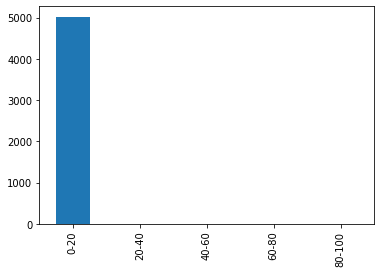

In [50]:
peaks.sum().plot(kind='bar', stacked=True)